In [2]:
from view_demo.utils import env_vars as evar

experiment_prefix = evar.EXPERIMENT_PREFIX
project_id = evar.PROJECT_ID
dataset_id = evar.DATASET_ID
table_id = evar.TABLE_ID
staging_bucket = evar.STAGING_BUCKET
location = evar.REGION
experiment_prefix = evar.EXPERIMENT_PREFIX
context_window = evar.CONTEXT_WINDOW
tf_serving_image = evar.TF_SERVING_IMAGE

In [3]:
#a = [c for c in df.columns]
#', '.join(a)
#print(a)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, timestamp_col_name, data_col_name, forecast_output=None, actual=None):
  input_timeseries = input_timeseries.sort_values(timestamp_col_name)    

  plt.figure(figsize=(20,6))
  plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
  plt.xlabel(timestamp_col_name)
  plt.ylabel(data_col_name)

  if forecast_output is not None:
    forecast_output = forecast_output.sort_values('forecast_timestamp')
    forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
    x_data = forecast_output['forecast_timestamp']
    y_data = forecast_output['forecast_value']
    confidence_level = forecast_output['confidence_level'].iloc[0] * 100
    low_CI = forecast_output['confidence_interval_lower_bound']
    upper_CI = forecast_output['confidence_interval_upper_bound']
    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
    # Shade the confidence interval
    plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = str(confidence_level) + '% confidence interval')

  # actual
  if actual is not None:
    actual = actual.sort_values(timestamp_col_name)
    plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

  # Display legend
  plt.legend(loc = 'upper center', prop={'size': 16})

In [5]:
%%bigquery df
SELECT DISTINCT
   CAST(PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time) as TIMESTAMP) as Date_Time,
   T__degC as Temperature
FROM
  `pytorch-tpu-nfs.view_dataset.weather_time_series`
WHERE EXTRACT(date from PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time)) BETWEEN '2016-01-15' AND '2016-02-15'
ORDER BY Date_Time ASC 

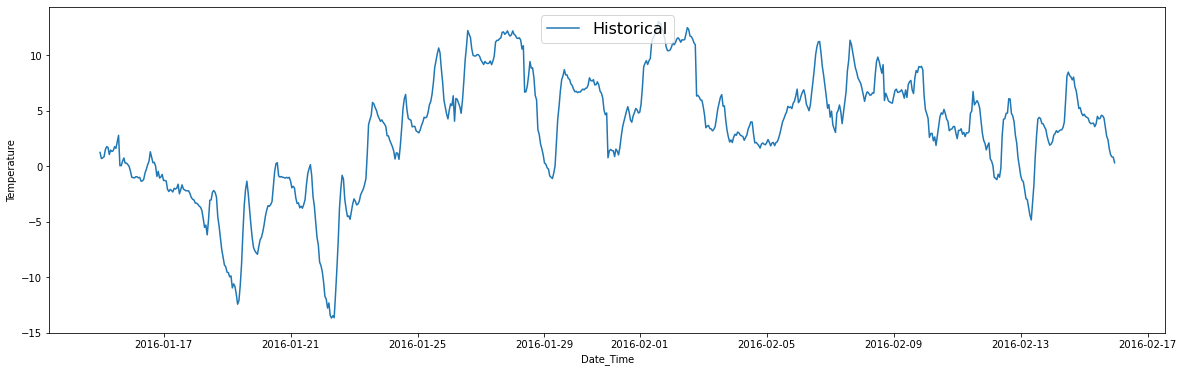

In [6]:
plot_historical_and_forecast(df, 'Date_Time', 'Temperature');

In [7]:
%%bigquery
CREATE OR REPLACE MODEL `pytorch-tpu-nfs.view_dataset.temperature-model`
OPTIONS(model_type='ARIMA_PLUS',
        time_series_data_col='T__degC',
        time_series_timestamp_col='Date_Time'
        )
AS
SELECT DISTINCT 
        CAST(PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time) as TIMESTAMP) as Date_Time,
        T__degC 
FROM `pytorch-tpu-nfs.view_dataset.weather_time_series`
WHERE EXTRACT(date from PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time)) BETWEEN '2012-01-15' AND '2016-02-15'
ORDER BY Date_Time ASC 

""


In [8]:
%%bigquery fcst
SELECT * FROM ML.FORECAST(MODEL `pytorch-tpu-nfs.view_dataset.temperature-model`, 
                  STRUCT(200 AS horizon, 0.9 AS confidence_level))

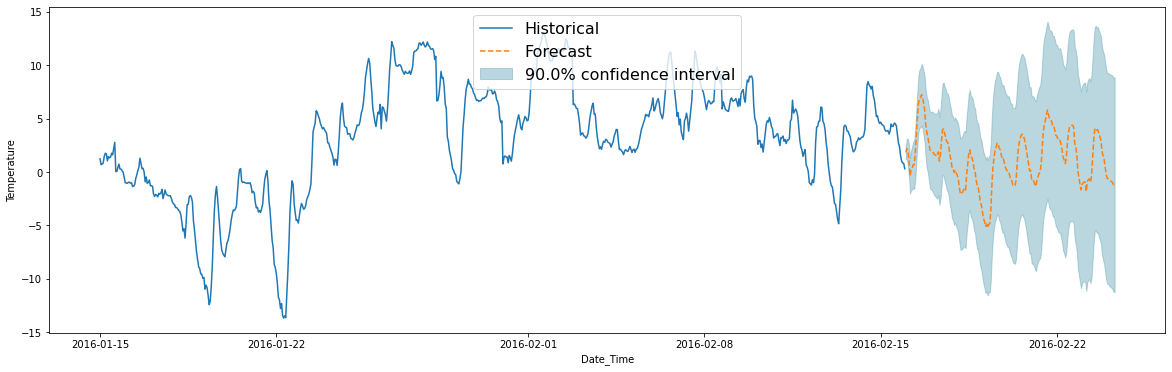

In [9]:
plot_historical_and_forecast(df, 'Date_Time', 'Temperature', fcst);

In [ ]:
%%bigquery actual
SELECT
   CAST(PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time) as TIMESTAMP) as Date_Time,
   T__degC as Temperature
FROM
  `pytorch-tpu-nfs.view_dataset.weather_time_series`
WHERE EXTRACT(date from PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time)) BETWEEN '2016-02-15' AND '2016-02-28'

In [ ]:
plot_historical_and_forecast(df, 'Date_Time', 'Temperature', fcst, actual);